# 预告片：使用Python进行生物图像分析
在接下来的章节中，我们将深入研究使用Python进行图像分析、机器学习和生物统计。这第一个notebook作为我们将要做的事情的预告片。

Python notebook通常以导入notebook将使用的Python库开始。读者可以首先检查是否所有这些库都已安装，然后再浏览整个notebook。

In [1]:
import numpy as np
from skimage.io import imread, imshow
import pyclesperanto_prototype as cle
from skimage import measure
import pandas as pd
import seaborn
import apoc
import stackview

## 处理图像数据
我们首先加载感兴趣的图像数据。在这个例子中，我们加载了一张显示斑马鱼眼睛的图像，感谢Mauricio Rocha Martins, Norden实验室, MPI CBG德累斯顿。

StackViewNDArray([[14709, 17195, 15101, ..., 10977, 10615, 10864],
                  [15234, 16786, 16048, ..., 11350, 11110, 11061],
                  [15709, 15896, 16645, ..., 11334, 10853, 10584],
                  ...,
                  [22707, 22025, 23783, ..., 16773, 17757, 16991],
                  [22484, 24699, 21860, ..., 16546, 16348, 17791],
                  [23357, 21872, 23148, ..., 18280, 18107, 17240]],
                 dtype=uint16)
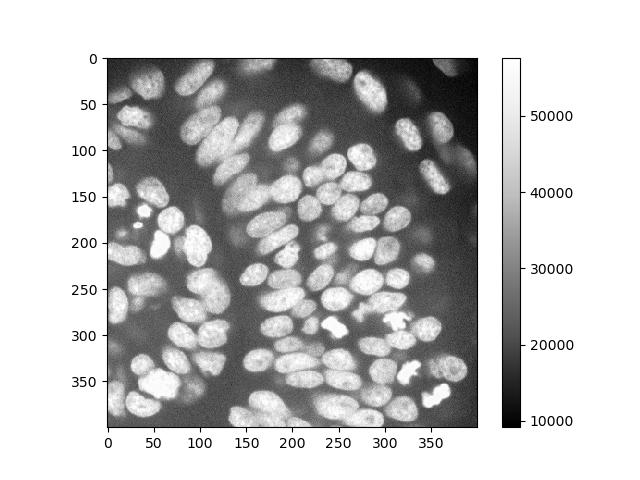
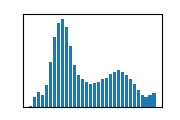

In [2]:
# open an image file
multichannel_image = imread("../../data/zfish_eye.tif")

# extract a channel
single_channel_image = multichannel_image[:,:,0]

cropped_image = single_channel_image[200:600, 500:900]

stackview.insight(cropped_image)

## 图像滤波

处理荧光显微镜图像时，一个常见的步骤是减去背景强度，例如由焦外光产生的背景强度。这可以进一步改善工作流程中的图像分割结果。

StackViewNDArray([[1279., 3765., 1671., ..., 1790., 1428., 1677.],
                  [1804., 3356., 2618., ..., 2163., 1923., 1874.],
                  [2279., 2466., 3215., ..., 2147., 1666., 1397.],
                  ...,
                  [1608.,  926., 2684., ..., 1342., 2326., 1560.],
                  [1385., 3600.,  761., ..., 1115.,  917., 2360.],
                  [2280.,  795., 2071., ..., 2849., 2676., 1809.]],
                 dtype=float32)
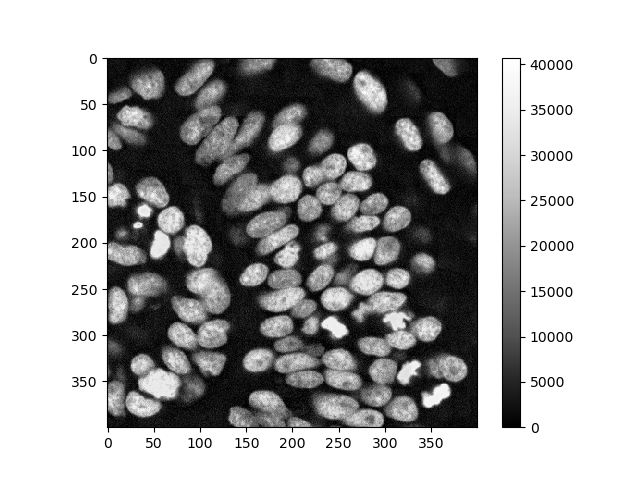
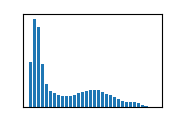

In [3]:
# subtract background using a top-hat filter
background_subtracted_image = cle.top_hat_box(cropped_image, radius_x=20, radius_y=20)

stackview.insight(background_subtracted_image)

## 图像分割
对于给定图像中的细胞核分割，存在大量算法。这里我们使用一种名为Voronoi-Otsu标记的经典方法，虽然它并不完美。

StackViewNDArray([[0, 0, 0, ..., 0, 0, 0],
                  [0, 0, 0, ..., 0, 0, 0],
                  [0, 0, 0, ..., 0, 0, 0],
                  ...,
                  [0, 0, 0, ..., 0, 0, 0],
                  [0, 0, 0, ..., 0, 0, 0],
                  [0, 0, 0, ..., 0, 0, 0]], dtype=uint32)
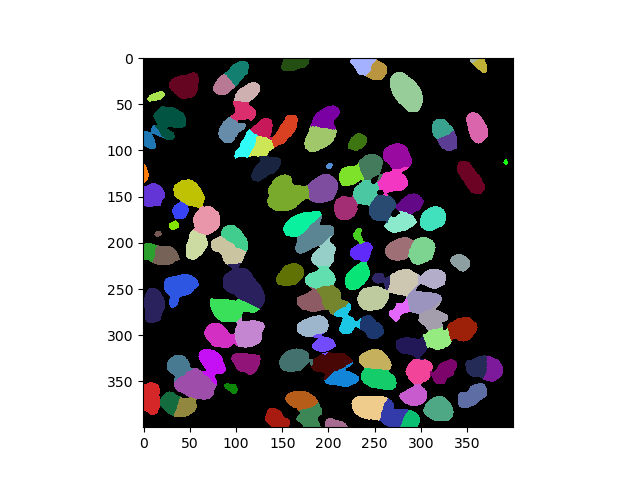

In [4]:
label_image = np.asarray(cle.voronoi_otsu_labeling(background_subtracted_image, spot_sigma=4))

# show result
stackview.insight(label_image)

## 测量和特征提取
图像分割后，我们可以测量单个对象的属性。这些属性通常是描述性统计参数，称为特征。当我们得出面积或平均强度等测量结果时，我们就提取了这两个特征。

In [5]:
statistics = measure.regionprops_table(label_image, 
                                       intensity_image=cropped_image,
                                       properties=('area', 'mean_intensity', 'major_axis_length', 'minor_axis_length'))

## 处理表格
上面创建的`statistics`对象包含一个Python数据结构，即测量向量的字典，这不是最直观的查看方式。因此，我们将其转换为表格。数据科学家经常将这些表格称为DataFrame，它们在[pandas](https://pandas.pydata.org/)库中可用。

In [6]:
dataframe = pd.DataFrame(statistics)

我们可以使用现有的表格列来计算其他测量值，比如`aspect_ratio`。

In [7]:
dataframe['aspect_ratio'] = dataframe['major_axis_length'] / dataframe['minor_axis_length']
dataframe

area  mean_intensity  major_axis_length  minor_axis_length  aspect_ratio
0    294.0    36604.625850          25.656180          18.800641      1.364644
1     91.0    37379.769231          20.821990           6.053507      3.439658
2    246.0    44895.308943          21.830827          14.916032      1.463581
3    574.0    44394.637631          37.788705          19.624761      1.925563
4    518.0    45408.903475          26.917447          24.872908      1.082199
..     ...             ...                ...                ...           ...
108  568.0    48606.121479          37.357606          19.808121      1.885974
109  175.0    25552.074286          17.419031          13.675910      1.273702
110  460.0    39031.419565          26.138592          23.522578      1.111213
111  407.0    39343.292383          28.544027          19.563792      1.459023
112   31.0    29131.322581           6.892028           5.711085      1.206781

[113 rows x 5 columns]

## 绘图
可以使用绘图来可视化测量结果。

<Axes: xlabel='area', ylabel='aspect_ratio'>

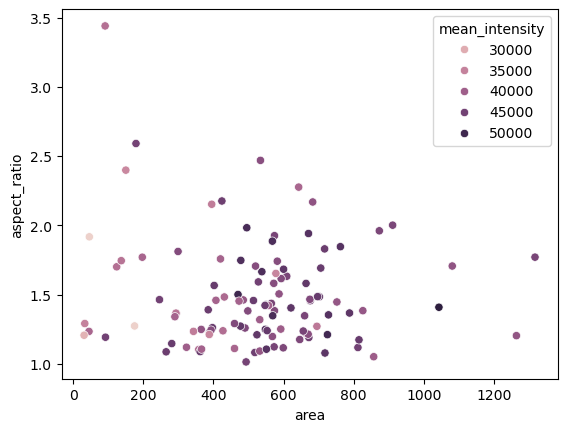

In [8]:
seaborn.scatterplot(dataframe, x='area', y='aspect_ratio', hue='mean_intensity')

## 描述性统计
以此表格为起点，我们可以使用统计数据来概述测量的数据。

In [9]:
mean_area = np.mean(dataframe['area'])
stddev_area = np.std(dataframe['area'])

print("平均细胞核面积为", mean_area, "+-", stddev_area, "像素")

Mean nucleus area is 524.4247787610619 +- 231.74703195433014 pixels


## 分类
为了更好地理解组织的内部结构，同时也为了纠正图像处理工作流程中的人为错误，我们可以对细胞进行分类，例如根据它们的大小和形状。

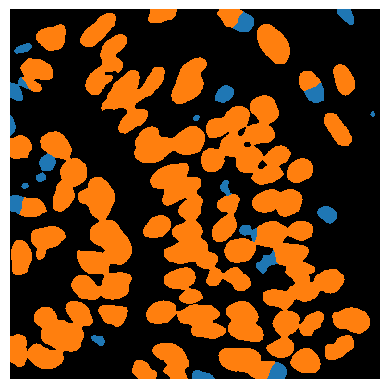

In [10]:
object_classifier = apoc.ObjectClassifier('../../data/blobs_classifier.cl')
classification_image = object_classifier.predict(label_image, cropped_image)

stackview.imshow(classification_image)